<a href="https://colab.research.google.com/github/GuilhermeRLDev/DeepLearningExperiments/blob/main/PositionalEmbbedingAMTTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import relevant libraries to build model
!pip install pretty_midi
!pip install wget
!pip install jams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install positional-encodings[pytorch,tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import random
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa as lr
from positional_encodings.tf_encodings import TFPositionalEncoding1D, TFSummer

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [1]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class AudioFeatureEmbeddingCNN(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        print("passed conv 1")
        x = self.conv2(x)
        print("passed conv 2")
        return self.conv2(x)


def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    print(vocab_size)
    print(d_model)
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=250, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    #x = self.embedding(x)

    # Return the inputs with the position encoding added
    add_p_enc_2d = TFSummer(TFPositionalEncoding1D(170))
    
    x = add_p_enc_2d(x)

    print(f"Shape: {x.shape}")

    return x

class TestEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


NameError: ignored

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm

In [ ]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = AudioFeatureEmbeddingCNN(num_hid=num_hid, maxlen=source_maxlen)
        #self.enc_input = TestEmbedding(source_maxlen, num_hid)
        #self.enc_input = PositionalEmbedding(num_hid, source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        
        x = self.encoder(source)
        
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            print(np.shape(logits))
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [ ]:
import jams

#Processing data for encoder
#Constants 
GUITAR_DATASET = "gdrive/MyDrive/datasets"

#Loading and preprocessing functions
def load_dataset(path, total_samples):
  '''
    Return x number of samples from disk 
  '''
  data_path = f"{path}/data"
  labels_path = f"{path}/labels"
  data = os.listdir(data_path)
  labels = os.listdir(labels_path)

  files = []
  i = 0
  for file in labels:

    if i == total_samples:
      break

    file_name = file.split(".")[0]
    if file_name in files:
      continue

    # Load data and anotation for the samples
    files.append({"audio":f"{data_path}/{file_name}_hex.wav", "label":f"{labels_path}/{file_name}.jams"})
    i += 1

  return files

In [ ]:
files = load_dataset(GUITAR_DATASET, 360)

print(len(files))

360


In [ ]:
!pip install ddsp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.6/212.6 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 KB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 KB 36.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 KB 28.2 MB/s eta 0:00:00
     ━━━━━━

In [ ]:
import matplotlib.pyplot as plt
from ddsp import spectral_ops
import numpy as np

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pretty_midi
from ddsp import spectral_ops

SAMPLING_RATE = 16000
HOP_SIZE =  128

class NoteEvents:
  def __init__(self, time):
    self.time = time
    self.notes_on = []
    self.notes_off = []
    self.mapping_dictionary = {'note': 0, 'on': 1, 'off': 2}

  def add_velocity(self, velocity):
    self.velocity = velocity
  
  def add_note_on(self, note):
    self.notes_on.append(note)

  def add_note_off(self, note):
    self.notes_off.append(note)

  def to_string(self):
    #0-250
    events = [f"<time {self.time}>"]

    if (len(self.notes_off) > 0):
      events.append('<off>')
      for note in self.notes_off:
        events.append(f'<note {note}>' )

    if (len(self.notes_on) > 0):
      events.append('<on>')
      for note in self.notes_on:
        events.append(f'<note {note}>' )

    return events

  def to_numeric_representation(self):
    events = []

    # 0 to 250
    events.append(self.time)

    if (len(self.notes_off) > 0):
      events.append(251)
      for note in self.notes_off:
        events.append(note + 252) # Add notes event
      
    if (len(self.notes_on)>0):    
      events.append(252) # Add note on event 
      for note in self.notes_on:
        events.append(note + 252) # Add notes event#

    return events

def parse(events):
  notes = []
  current_note = NoteEvents(0)
  for event in events:
    state = 0
    if event < 251:
      current_note = NoteEvents(event)
      notes.append(current_note)
      state = 0
    elif event == 251:
      state = 251
    elif event == 252:
      state = 252
    elif event > 252:
      if (state == 251):
        current_note.add_note_off(event-252) # Remove 252 events related to time 
      else:
        current_note.add_note_on(event-252) # Remove 252 events related to time

  return notes 


def to_vacab(times, midi_annotations):

  labels = MT3_labelling_data(times, midi_annotations)

  labels = [l.to_numeric_representation() for l in labels]
  labels = np.concatenate(labels)

  labels = labels.astype(int)

  return labels

class MusicDataGenerator:
  def __init__(self, files, batch_size):
    #Audio and labels location 
    self.files = files
    #Define the batch size for each epohc
    self.batch_size = batch_size
    #start fetching music from index 0 

    self.current_index = 0



  def build_numeric_vocab(self, labels, total_notes):
    numeric_vocab = {'shift': 0}

    for note in range(1, total_notes):
      note_on = f'NoteOn{note}'
      numeric_vocab[note_on] = note

      note_off = f'NoteOff{note}'
      numeric_vocab[note_off] = note +128

    results = []

    for token in labels:
        results.append(numeric_vocab[token])
      
    return np.array(results), list(numeric_vocab.values())

  
  def build_numeric_vocab_old(self, labels, total_notes):
    numeric_vocab = {'shift': 1, 'on': 2, 'off': 3 }

    for note in range(total_notes):
      note_label = f'note{note}'
      numeric_vocab[note_label] = note+4

    results = []

    for token in labels:
        results.append(numeric_vocab[token])
      
    return np.array(results), list(numeric_vocab.values())

  #Get the nearest neighbour to build an event start
  def __len__(self):
    return int(len(self.files)/self.batch_size)

  def __getitem__(self, total, bs = 4):
    X = []
    y = []

    padding_costant = np.zeros(128)

    i= 0
  
    for file in self.files:
      if (i == total): 
        break

      spectograms, times = self.get_spectogram_time(file['audio'])

      #Initialy encoded to load labels as jam 
      jams_labels = jams.load(file['label'])
      #Convert to vocabulary
      pretty_midi = self.jams_to_midi(jams_labels)

      #spectograms = spectograms[:, 0,:]

      #Padding music signal 
      if ((len(spectograms) % 250) > 0):
        delta = 250-(len(spectograms) % 250) 

        for i in range(delta):
          spectograms = np.append(spectograms, [padding_costant], axis=0)

      midi_events = self.midi2list(pretty_midi)


      vocab = np.array(to_vacab(times, midi_events))

      print(list(midi_events[:, 1]))

      print(list(vocab))

      vocab_per_segment = []
      events_vocab = []

      for item in vocab:
        if (item == 0):
          events_vocab = []

        if (item == 250):
          vocab_per_segment.append(events_vocab)
          
        events_vocab.append(item)

      for i, segment in enumerate(vocab_per_segment):
        delta = 512 - len(segment) 

        if (delta >0):
          padding_array = np.arange(delta)
          vocab_per_segment[i] = np.append(segment, padding_array)

            
      print(f"Size of vocab {np.shape(vocab_per_segment)}")
      print(f"Times {np.shape(times)}")
      print(f"Vocab {np.shape(vocab)}")

      print(f"size of frames: {len(spectograms)}")
      x_prime = None
      if (len(X) == 0):
        x_prime = np.array_split(spectograms, len(spectograms)/250)
        X = x_prime
      else:
        x_prime = np.array_split(spectograms, len(spectograms)/250)
        
        for item in x_prime:
          X.append(item)
      
      print(f"size of vocabulary: {len(vocab)}")

      for item in vocab_per_segment:
        y.append(item)

      print(np.shape(X))
      print(np.shape(y))

      i+= 1 

    X = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(y)

    ds = tf.data.Dataset.zip((X, y))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
  
    return ds

m_generator = MusicDataGenerator(files[0:100], 32)
ds = m_generator.__getitem__(1)

AttributeError: ignored

In [ ]:
#Rewrite this function to convert jams to Midi
def jams_to_midi(jam, q=1):
    #Create 
    midi = pretty_midi.PrettyMIDI()
    annotations = jam.search(namespace='note_midi')
    if len(annotations) == 0:
        annotations = jam.search(namespace='pitch_midi')
    for anno in annotations:
        midi_ch = pretty_midi.Instrument(program=25)
        for note in anno:
            pitch = int(round(note.value))
            bend_amount = int(round((note.value - pitch) * 4096))
            st = note.time
            dur = note.duration
            n = pretty_midi.Note(
                velocity=100 + np.random.choice(range(-5, 5)),
                pitch=pitch, start=st,
                end=st + dur
            )
            pb = pretty_midi.PitchBend(pitch=bend_amount * q, time=st)
            midi_ch.notes.append(n)
            midi_ch.pitch_bends.append(pb)
        if len(midi_ch.notes) != 0:
            midi.instruments.append(midi_ch)
    return midi

def midi2list(midi):
    midi_list = []

    for instrument in midi.instruments:
      for note in instrument.notes:
        midi_list.append([note.start, note.end, note.pitch, note.velocity])

    return np.array(midi_list)

In [ ]:
#Follow same thresholds define by 
SAMPLE_RATE = 16000
HOP_SIZE = 128
FFT_SIZE = 256

def get_spectogram_time(signals, sr):
  '''
    Function build according to MT3 paper
  '''
  spectograms = []
  for signal in signals:
    spectograms.append(lr.feature.melspectrogram(y=np.array(signal), sr=sr, hop_length=512))

  #Generate mel_spectograms 50% overlap
  #spectograms = spectral_ops.compute_logmel(
  #    signal,
  #    bins=512,
  #    lo_hz=20.0,
  #    overlap=0.5,
  #    fft_size=FFT_SIZE,
  #    sample_rate=SAMPLE_RATE)

  return spectograms

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def plot_spectogram(y, sr, M=None):
  fig, ax = plt.subplots()
  if M is None:
    M = lr.feature.melspectrogram(y=y, sr=sr)
  M_db = lr.power_to_db(M, ref=np.max)
  img = lr.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
  ax.set(title='Mel spectrogram display')
  fig.colorbar(img, ax=ax, format="%+2.f dB")

(25, 128, 32)
(25, 16000)
(25, 128, 32)
[[3.6657382e-02 9.4226114e-03 3.0538256e-05 ... 3.0455789e-02
  8.4358006e-04 8.0476422e-04]
 [4.3086819e-02 1.0733760e-02 3.9071264e-07 ... 3.0275380e-02
  1.3492212e-03 7.4661057e-04]
 [5.6423176e-02 1.4082980e-02 2.4200733e-06 ... 8.8629313e-03
  5.7591067e-04 1.2272577e-03]
 ...
 [9.7127995e-06 2.4386500e-06 1.2454079e-08 ... 1.2838397e-06
  1.7768288e-07 6.3457520e-07]
 [9.1993243e-06 2.3005412e-06 9.9661102e-10 ... 2.6043557e-07
  1.7194419e-07 7.3339493e-07]
 [8.4439789e-06 2.1109545e-06 1.3440367e-11 ... 1.2384408e-09
  6.6396552e-08 6.3948602e-07]]


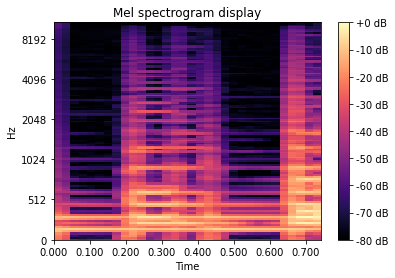

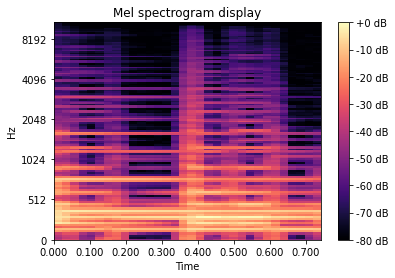

In [ ]:
def split_audio(path_to_audio, size_in_secs=1):
  signal, sr = lr.load(path_to_audio)

  if sr != SAMPLE_RATE:
    signal = lr.resample(signal, sr, SAMPLE_RATE)

  if (len(signal) < (SAMPLE_RATE * 25)):
    signal = np.pad(signal, [0, (SAMPLE_RATE * 25) - len(signal)], mode='constant')

  if (len(signal) > (SAMPLE_RATE * 25)):
    signal =  signal[0:(SAMPLE_RATE * 25)]

  frames_per_second = SAMPLE_RATE / HOP_SIZE
  
  if (len(signal) % HOP_SIZE) > 0:
    signal = np.pad(signal, [0, HOP_SIZE - len(signal) % HOP_SIZE], mode='constant')

  #Split audio in chunks 
  size_split = int(size_in_secs * SAMPLE_RATE) 
  segments = tf.signal.frame(signal, frame_length=size_split,frame_step=size_split, pad_end=True)
  spectograms = get_spectogram_time(segments, SAMPLE_RATE)

  print(np.shape(spectograms))

  times = []
  for segment in segments: 
    #Get the times array for the segment
    frames_per_segment = tf.signal.frame(segment, frame_length=HOP_SIZE,frame_step=HOP_SIZE, pad_end=True)
    times_for_segment = np.arange(len(frames_per_segment)) / frames_per_second
    times.append(times_for_segment)

  print(np.shape(segments))
  print(np.shape(spectograms))

  return segments, times, spectograms, sr
    
#Testing function for spectograms
segments, times, spectograms, sr = split_audio(files[0]['audio'])

#print(spectograms[0])
plot_spectogram(None, SAMPLE_RATE, spectograms[0])
print(lr.feature.melspectrogram(y=np.array(segments[0]), sr=SAMPLE_RATE))
plot_spectogram(np.array(segments[1]), SAMPLE_RATE)



In [ ]:
def get_events(start, end, midi, times, parsed=False):
  events = [NoteEvents(i) for i in range(len(times))]
  #Get start events that start on this segment to populate notes on
  start_time_filter = (midi[:,0] >= start) & (midi[:,0] <= end)
  notes_on = midi[start_time_filter]

  #Get notes off events 
  end_times_filter =  (midi[:,1] >=start) & (midi[:,1] <= end)
  notes_off = midi[end_times_filter] 

  #Create an array of note events
  times = np.reshape(times, (-1, 1))
  for note in notes_on:
    distance = np.linalg.norm(times-note[0], axis=1)
    index = np.argmin(np.linalg.norm(times-note[0], axis=1))
    events[index].add_note_on(note[2])

  #Create an array of note events
  for note in notes_off:
    index = np.argmin(np.linalg.norm(times-note[1], axis=1))
    events[index].add_note_off(note[2])

  if (parsed):
    event = [event.to_string() for event in events if (len(event.notes_off)>0) or (len(event.notes_on)>0)]

    if len(event) == 0:
      event = [['unk']]


  print(event)
  return event

In [ ]:
def get_dataset(files):
    X = []
    y = []

    padding_costant = np.zeros(512)
    EOS = np.random.rand(512)

    for counter, file in enumerate(files):
      print(f"Processing sample {file['audio']} counter: {counter} - Shape: {np.shape(X)}")
      segments, times, spectograms, sr = split_audio(file['audio']) 
      print(len(spectograms))
      #Load MIDI from file
      jams_labels = jams.load(file['label'])
      pretty_midi = jams_to_midi(jams_labels)
      midi_events = midi2list(pretty_midi)

      labels = []
      index_remove = [] 
      for i, t_segment in enumerate(times):
        t_segment = t_segment + (i * 2) #Convert time to the full segment
        start_time = np.min(t_segment)
        end_time = np.max(t_segment) + 0.008 #TODO Receive the time per frame as parameter

        labels = get_events(start_time, end_time, midi_events, t_segment, True)
        labels = np.concatenate(labels)

        #Remove samples with no notes
        if len(labels) == 1:
          index_remove.append(i)
          continue

        labels = np.append(labels, ["<EOS>"])
        y.append(labels)

      index_remove = np.sort(index_remove)

      for i, segment in enumerate(spectograms):
        if i not in index_remove:
          X.append(segment)

    return (X, y)

X, y = get_dataset(files[0:320])

X_val, y_val = get_dataset(files[320:360])


Streaming output truncated to the last 5000 lines.
[['<time 2>', '<off>', '<note 53.0>'], ['<time 5>', '<on>', '<note 53.0>'], ['<time 32>', '<off>', '<note 53.0>', '<on>', '<note 55.0>'], ['<time 62>', '<off>', '<note 55.0>'], ['<time 66>', '<on>', '<note 57.0>'], ['<time 93>', '<off>', '<note 57.0>']]
[['<time 21>', '<off>', '<note 55.0>'], ['<time 54>', '<on>', '<note 63.0>'], ['<time 110>', '<off>', '<note 63.0>'], ['<time 114>', '<on>', '<note 62.0>']]
[['<time 36>', '<off>', '<note 57.0>'], ['<time 41>', '<on>', '<note 58.0>'], ['<time 71>', '<off>', '<note 58.0>', '<on>', '<note 57.0>'], ['<time 99>', '<on>', '<note 53.0>']]
[['<time 58>', '<on>', '<note 57.0>'], ['<time 63>', '<off>', '<note 62.0>'], ['<time 111>', '<off>', '<note 57.0>'], ['<time 115>', '<on>', '<note 57.0>']]
[['<time 15>', '<on>', '<note 63.0>'], ['<time 48>', '<off>', '<note 63.0>', '<on>', '<note 63.0>'], ['<time 78>', '<off>', '<note 63.0>', '<on>', '<note 62.0>'], ['<time 105>', '<off>', '<note 62.0>'], 

In [ ]:
#Convert a sequence of works to a token
class SimpleTokenizer:
  def __init__(self, y, unkown='<unk>'):
    self.y = y
    self.unkown = unkown
 
  def build_vocab(self):
    self.vocabulary = {}
    self.vocabulary[self.unkown] = 0

    for segment in self.y:
      for word in segment:
        if word not in self.vocabulary:
          self.vocabulary[word] = len(self.vocabulary)

    self.vocab_indexes = dict.fromkeys(list(self.vocabulary.values()), 0)
    
    for i, value in enumerate(list(self.vocabulary.keys())):
      self.vocab_indexes[i] = value

  def vocab_size(self):
    return len(self.vocabulary)

  def encode_input(self, y):
    result = []
    max_size = 0
    for segment in y:
      segment_encoded = []
      for word in segment:
        segment_encoded.append(self.vocabulary[word]) 

        #Save max_size to apply padding
        if (len(segment) > max_size):
          print(f"New  max size {len(segment)}")
          max_size = len(segment)

      result.append(segment_encoded)
    
    print(max_size)
    results_appended = []
    for item in result:
      if len(item) < max_size:
        while  len(item) < max_size:
          item.append(self.vocabulary[self.unkown])

      results_appended.append(item)

    return results_appended

  def decode_input(self, input):
    result = []
    for value in input:
      result.append(self.vocab_indexes[value]) 

    return  result

y_all = np.append(y, y_val)

print(np.shape(y_all))

tokenizer = SimpleTokenizer(y_all)
tokenizer.build_vocab()
y_encoded = tokenizer.encode_input(y_all)

y_decoded = tokenizer.decode_input(y_encoded[0])

print(f"Vocab Size: {tokenizer.vocab_size()}")

(5528,)
New  max size 52
New  max size 74
New  max size 87
New  max size 96
New  max size 101
New  max size 172
New  max size 211
211
Vocab Size: 171


In [ ]:
def build_dataset(X, y, tokenizer, bs=4):
  #Encode target
  y_encoded = np.array(tokenizer.encode_input(y))

  X = tf.data.Dataset.from_tensor_slices(X)
  y = tf.data.Dataset.from_tensor_slices(y_encoded)

  ds = tf.data.Dataset.zip((X, y))
  ds = ds.map(lambda x, y: {"source": x, "target": y})
  ds = ds.batch(bs)
  ds = ds.prefetch(tf.data.AUTOTUNE)

  return ds

ds = build_dataset(X, y, tokenizer, 36)
val_ds = build_dataset(X_val, y_val, tokenizer, 36)

New  max size 52
New  max size 74
New  max size 87
New  max size 96
New  max size 101
New  max size 172
New  max size 211
211
New  max size 24
New  max size 35
New  max size 44
New  max size 52
New  max size 60
New  max size 76
New  max size 89
New  max size 106
106


TODO: Experiment with differet types of tokenizer

In [ ]:
batch = next(iter(ds))

print(tokenizer.decode_input(np.array(batch['target'][2])))

print(type(np.array(batch['target'][0])[0]))

['<time 7>', '<off>', '<note 56.0>', '<on>', '<note 56.0>', '<time 9>', '<off>', '<note 61.0>', '<on>', '<note 61.0>', '<time 14>', '<off>', '<note 65.0>', '<time 17>', '<on>', '<note 65.0>', '<time 23>', '<off>', '<note 49.0>', '<time 24>', '<on>', '<note 49.0>', '<time 27>', '<off>', '<note 56.0>', '<on>', '<note 56.0>', '<time 47>', '<off>', '<note 56.0>', '<time 48>', '<on>', '<note 56.0>', '<time 66>', '<off>', '<note 49.0>', '<on>', '<note 49.0>', '<time 67>', '<off>', '<note 56.0>', '<time 71>', '<on>', '<note 56.0>', '<time 95>', '<off>', '<note 56.0>', '<time 100>', '<on>', '<note 57.0>', '<time 101>', '<off>', '<note 49.0>', '<on>', '<note 49.0>', '<EOS>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
model = Transformer(
    num_hid=200,
    num_head=2,
    num_feed_forward=400,
    source_maxlen=128,
    target_maxlen=212,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=tokenizer.vocab_size(),
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)

learning_rate = CustomSchedule(128)
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(ds, validation_data=val_ds, epochs=50)

Epoch 1/50
137/137 [==============================] - 26s 66ms/step - loss: 0.7119 - val_loss: 1.1537
Epoch 2/50
137/137 [==============================] - 3s 25ms/step - loss: 0.5694 - val_loss: 1.0336
Epoch 3/50
137/137 [==============================] - 3s 24ms/step - loss: 0.5244 - val_loss: 0.9776
Epoch 4/50
137/137 [==============================] - 3s 24ms/step - loss: 0.5045 - val_loss: 0.9523
Epoch 5/50
137/137 [==============================] - 3s 24ms/step - loss: 0.4861 - val_loss: 0.9078
Epoch 6/50
137/137 [==============================] - 3s 25ms/step - loss: 0.4633 - val_loss: 0.8786
Epoch 7/50
137/137 [==============================] - 3s 25ms/step - loss: 0.4494 - val_loss: 0.8574
Epoch 8/50
137/137 [==============================] - 3s 24ms/step - loss: 0.4404 - val_loss: 0.8462
Epoch 9/50
137/137 [==============================] - 3s 24ms/step - loss: 0.4334 - val_loss: 0.8355
Epoch 10/50
137/137 [==============================] - 3s 25ms/step - loss: 0.4268 - val_l

In [ ]:
history = model.fit(ds, validation_data=val_ds, epochs=50)

Epoch 1/50
5/5 [==============================] - 0s 34ms/step - loss: 1.2348 - val_loss: 1.0140
Epoch 2/50
5/5 [==============================] - 0s 32ms/step - loss: 1.2255 - val_loss: 1.0111
Epoch 3/50
5/5 [==============================] - 0s 32ms/step - loss: 1.2160 - val_loss: 1.0082
Epoch 4/50
5/5 [==============================] - 0s 33ms/step - loss: 1.2062 - val_loss: 1.0055
Epoch 5/50
5/5 [==============================] - 0s 34ms/step - loss: 1.1964 - val_loss: 1.0032
Epoch 6/50
5/5 [==============================] - 0s 33ms/step - loss: 1.1868 - val_loss: 1.0010
Epoch 7/50
5/5 [==============================] - 0s 33ms/step - loss: 1.1774 - val_loss: 0.9988
Epoch 8/50
5/5 [==============================] - 0s 31ms/step - loss: 1.1681 - val_loss: 0.9965
Epoch 9/50
5/5 [==============================] - 0s 31ms/step - loss: 1.1588 - val_loss: 0.9942
Epoch 10/50
5/5 [==============================] - 0s 31ms/step - loss: 1.1496 - val_loss: 0.9923
Epoch 11/50
5/5 [============

In [ ]:
model.save_weights("gdrive/MyDrive/my_checkpoints")

In [ ]:
batch = next(iter(val_ds))
print(batch['source'].shape)
values = batch['source']

(36, 128, 32)


In [ ]:
# Returns the position encoding only
p_enc_2d = TFPositionalEncoding1D(1000)
print(p_enc_2d(values).shape)
# Return the inputs with the position encoding added
add_p_enc_2d = TFSummer(TFPositionalEncoding1D(170))
values = add_p_enc_2d(values)

print(values.shape)


(36, 128, 32)
(36, 128, 32)


In [ ]:
batch = next(iter(ds))
print(batch)

preds = model.generate(batch['source'], 1)

print(preds.shape)
print(list(np.array(preds[1])))
print(list(np.array(batch['target'][1])))

{'source': <tf.Tensor: shape=(36, 128, 32), dtype=float32, numpy=
array([[[3.66573818e-02, 9.42261145e-03, 3.05382564e-05, ...,
         3.04557886e-02, 8.43580056e-04, 8.04764219e-04],
        [4.30868194e-02, 1.07337600e-02, 3.90712643e-07, ...,
         3.02753802e-02, 1.34922122e-03, 7.46610574e-04],
        [5.64231761e-02, 1.40829803e-02, 2.42007332e-06, ...,
         8.86293128e-03, 5.75910672e-04, 1.22725766e-03],
        ...,
        [9.71279951e-06, 2.43864997e-06, 1.24540787e-08, ...,
         1.28383965e-06, 1.77682878e-07, 6.34575201e-07],
        [9.19932427e-06, 2.30054115e-06, 9.96611016e-10, ...,
         2.60435570e-07, 1.71944194e-07, 7.33394927e-07],
        [8.44397891e-06, 2.11095448e-06, 1.34403669e-11, ...,
         1.23844079e-09, 6.63965523e-08, 6.39486018e-07]],

       [[1.40251149e-03, 6.51059579e-03, 5.30862994e-03, ...,
         9.07713766e-05, 1.16361553e-04, 3.49690526e-04],
        [6.17195561e-04, 1.97396823e-03, 2.61626835e-03, ...,
         7.930114

In [ ]:
p = list(np.array(preds[1]))
prediction = tokenizer.decode_input(p)
print(prediction)


print(tokenizer.decode_input(list(np.array(batch['target'][1]))))
  

['<time 1>', '<on>', '<note 59.0>', '<note 62.0>', '<note 67.0>', '<note 69.0>', '<time 25>', '<off>', '<note 59.0>', '<time 33>', '<off>', '<note 59.0>', '<on>', '<note 59.0>', '<note 64.0>', '<on>', '<note 69.0>', '<time 34>', '<off>', '<note 59.0>', '<on>', '<note 59.0>', '<time 35>', '<off>', '<note 59.0>', '<time 36>', '<on>', '<note 59.0>', '<time 37>', '<on>', '<note 69.0>', '<time 38>', '<on>', '<note 69.0>', '<time 72>', '<off>', '<note 59.0>', '<time 74>', '<on>', '<note 59.0>', '<note 68.0>', '<time 75>', '<off>', '<note 69.0>', '<time 76>', '<off>', '<note 69.0>', '<on>', '<note 69.0>', '<time 106>', '<off>', '<note 59.0>', '<time 107>', '<off>', '<note 69.0>', '<time 108>', '<on>', '<note 69.0>', '<time 109>', '<off>', '<note 59.0>', '<time 109>', '<on>', '<note 59.0>', '<time 109>', '<on>', '<note 59.0>', '<time 110>', '<off>', '<note 59.0>', '<time 111>', '<on>', '<note 59.0>', '<EOS>', '<on>', '<note 59.0>', '<on>', '<note 59.0>', '<EOS>', '<EOS>', '<time 111>', '<on>',